In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator
import scipy.signal
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import dill
import sys
sys.path.append('../')
from modelfitting import train_test_split, ROC_curve, PR_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction

In [2]:
datapath = '/mnt/ssd/workspace/stability/MLstability/training_data/'
dset = 'resonant/'
featurefolder = 'ressummaryfeaturesxgbNorbits10000.0Nout1000/'
features = ['megno']

In [3]:
trainingdatafolder = datapath+dset+featurefolder
trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features)

In [5]:
space ={
        'max_depth': hp.randint('x_max_depth',  20),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'scale_pos_weight': hp.uniform("x_pos_weight", 1, 15),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
}

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)
def objective(space):

    clf = XGBClassifier(n_estimators = 100, 
                            max_depth = space['max_depth'], 
                            min_child_weight =space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree =space['colsample_bytree'],
                            learning_rate = space['learning_rate'], seed = 0)
    
    params = clf.get_xgb_params()
    #dtest
    score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    #print score
    #score = cross_val_score(clf, trainX, trainY, cv = 5, scoring="average_precision")
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    bst = xgb.train(params, dtrain)
    preds = bst.predict(dtest)
    test_score = metrics.roc_auc_score(testY, preds)
    
    print("SCORE:", avg_score, "ERROR", error, "HOLDOUT SCORE", test_score)

    return{'loss':1-test_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error, "holdout":test_score }

/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [6]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.83580498                                          
ERROR                                               
0.004386544170922062                                
HOLDOUT SCORE                                       
0.8328826867007827                                  
SCORE:                                                                       
0.8446566800000002                                                           
ERROR                                                                        
0.0031071702951212766                                                        
HOLDOUT SCORE                                                                
0.8425146283727927                                                           
SCORE:                                                                        
0.83595854                                                                    
ERROR                                                   

0.004176767267413461                                                           
HOLDOUT SCORE                                                                  
0.8316174483923912                                                             
SCORE:                                                                         
0.8309205799999999                                                             
ERROR                                                                          
0.006165270752756342                                                           
HOLDOUT SCORE                                                                  
0.8380676433701512                                                             
SCORE:                                                                         
0.8268456399999999                                                             
ERROR                                                                          
0.0071810971436308685                   

0.004016709744625875                                                           
HOLDOUT SCORE                                                                  
0.8415931719473984                                                             
SCORE:                                                                         
0.8369513399999999                                                             
ERROR                                                                          
0.0033822774836812382                                                          
HOLDOUT SCORE                                                                  
0.8325762066643279                                                             
SCORE:                                                                         
0.83142052                                                                     
ERROR                                                                          
0.006629072040131708                    

In [10]:
best

{'x_learning_rate': 0.13612752208327664,
 'x_max_depth': 5,
 'x_min_child': 5.0,
 'x_pos_weight': 14.779641842871772,
 'x_subsample': 0.9992758653657869,
 'x_tree_colsample': 0.5299621363286435}

In [11]:
best_xgbc = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])
params = best_xgbc.get_xgb_params()
score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", verbose_eval=True)
print(score)
d_Train = xgb.DMatrix(trainX, trainY)
d_Test = xgb.DMatrix(testX)
bst = xgb.train(params, d_Train)
preds = bst.predict(d_Test)
score = metrics.average_precision_score(testY, preds)
print(score)

[0]	train-auc:0.852115+0.00200798	test-auc:0.837339+0.00562316
[1]	train-auc:0.854802+0.00219212	test-auc:0.840464+0.00450449
[2]	train-auc:0.856154+0.00141779	test-auc:0.842309+0.00410506
[3]	train-auc:0.856847+0.00112519	test-auc:0.84323+0.00379745
[4]	train-auc:0.857489+0.000949095	test-auc:0.843643+0.00462961
[5]	train-auc:0.858136+0.00079367	test-auc:0.844354+0.00470763
[6]	train-auc:0.859031+0.001187	test-auc:0.845221+0.00446678
[7]	train-auc:0.859981+0.00119573	test-auc:0.846197+0.00356505
[8]	train-auc:0.861951+0.000457878	test-auc:0.846731+0.00283288
[9]	train-auc:0.862363+0.000369093	test-auc:0.846873+0.00294862
   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.852115       0.002008       0.837339      0.005623
1        0.854802       0.002192       0.840464      0.004504
2        0.856154       0.001418       0.842309      0.004105
3        0.856847       0.001125       0.843230      0.003797
4        0.857489       0.000949       0.843643      0.00463

In [12]:
model = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

model.fit(trainX, trainY)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5299621363286435, gamma=0,
       learning_rate=0.13612752208327664, max_delta_step=0, max_depth=5,
       min_child_weight=5.0, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=14.779641842871772,
       seed=None, silent=True, subsample=0.9992758653657869)

Text(0.5, 1.0, 'ROC curve (AUC = 0.836)')

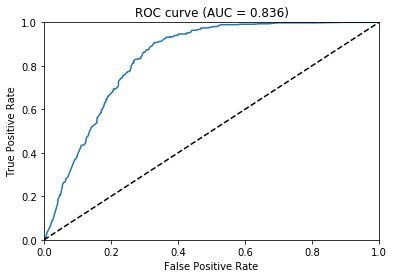

In [13]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [14]:
pr_auc, precision, recall, PRthresholds = PR_curve(trainingdatafolder, model, features)
for i in range(0,len(recall), 15):
    print("Threshold {0}, recall = {1}, precision = {2}".format(PRthresholds[i], recall[i], precision[i]))

Threshold 0.016028251498937607, recall = 1.0, precision = 0.3295695130557516
Threshold 0.0314330980181694, recall = 0.9978586723768736, precision = 0.3669291338582677
Threshold 0.05897511541843414, recall = 0.9978586723768736, precision = 0.38385502471169686
Threshold 0.1332569569349289, recall = 0.9914346895074947, precision = 0.41192170818505336
Threshold 0.273743599653244, recall = 0.9892933618843683, precision = 0.440419447092469
Threshold 0.3775845766067505, recall = 0.9785867237687366, precision = 0.4639593908629442
Threshold 0.477656751871109, recall = 0.9657387580299786, precision = 0.4813233724653148
Threshold 0.5697124004364014, recall = 0.9464668094218416, precision = 0.4966292134831461
Threshold 0.6904720067977905, recall = 0.9357601713062098, precision = 0.5159386068476978
Threshold 0.7928160429000854, recall = 0.9079229122055674, precision = 0.5442875481386393
Threshold 0.8424453139305115, recall = 0.8693790149892934, precision = 0.5569272976680384
Threshold 0.87207663059

IndexError: index 285 is out of bounds for axis 0 with size 285

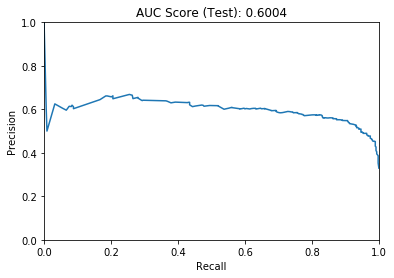

In [15]:
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title("AUC Score (Test): {0:.4f}".format(pr_auc))
plt.show()

(0, 168.3)

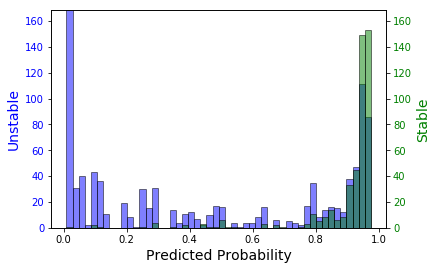

In [16]:
# Histogram:
bins = 50
Stable, Unstable = stable_unstable_hist(trainingdatafolder, model, features)

fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
#print(n)
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
#print(n.astype(int))
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,1.1*n[-1]]) # goes up to ~4300
ax2.set_ylim([0,1.1*n[-1]]) # goes up to ~2100

Text(0, 0.5, 'Fraction actually stable')

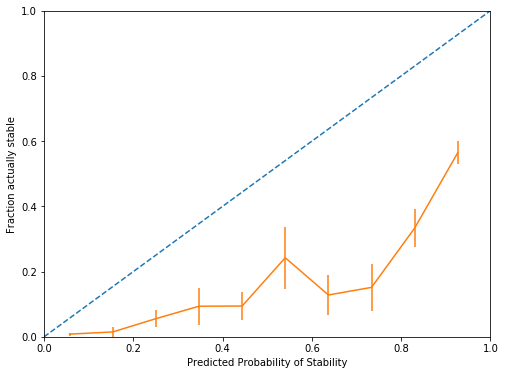

In [17]:
bincenters, fracstable, errorbars = calibration_plot(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')

Text(0.5, 1.0, 'Fraction of unstable systems mislabeled as stable')

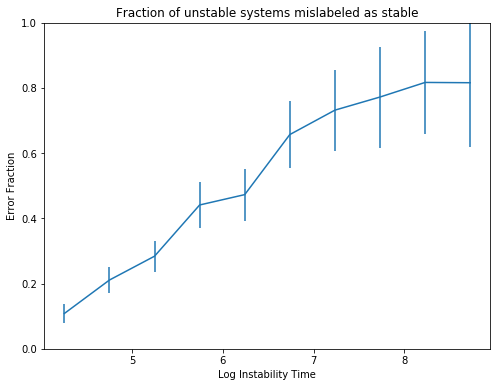

In [19]:
bincenters, errorfracs, errorbars = unstable_error_fraction(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(bincenters, errorfracs, errorbars)
ax.set_ylim([0,1])
ax.set_xlabel('Log Instability Time')
ax.set_ylabel('Error Fraction')
ax.set_title('Fraction of unstable systems mislabeled as stable')

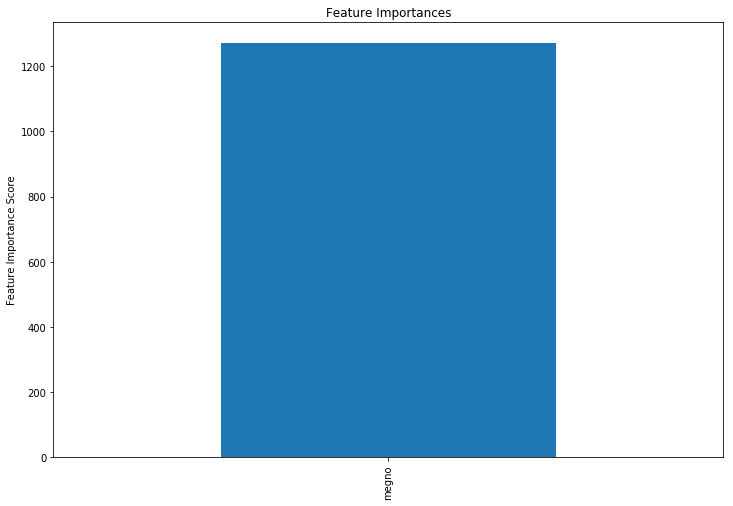

In [20]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

In [21]:
dill.dump([model, features, featurefolder], open(datapath+"../models/megnoxgb_resonant.pkl", "wb"))